# Run the LNN model

First, we have to create the PyTorch objects out of the NPZ files. NPZ files behave like dictionaries of arrays. In our case, they contain two keys:

- `X`: the featurized systems
- `y`: the associated measurements

We can pass those dict-like arrays to an adapter class for Torch Datasets, which will be ingested by the DataLoaders. We also need the corresponding observation models.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from collections import defaultdict
import numpy as np

import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
import pytorch_lightning as pl

from kinoml.utils import seed_everything
from kinoml.core import measurements as measurement_types
from kinoml.datasets.torch_datasets import XyNpzTorchDataset

HERE = Path(_dh[-1])
OUT = HERE / "_output/"
OUT.mkdir(parents=True, exist_ok=True)

# Fix the seed for reproducible random splits -- otherwise we get mixed train/test groups every time, biasing the model evaluation
seed_everything()

## Load featurized data and create observation models

In [3]:
datasets = defaultdict(dict)
for npz in HERE.glob("../_output/ChEMBL__*.npz"):
    _, kinase, measurement_type = str(npz.stem).split("__")
    datasets[kinase][measurement_type] = XyNpzTorchDataset(npz)

In [4]:
obs_models = {k: getattr(measurement_types, k).observation_model(backend="pytorch") for k in ["pKiMeasurement", "pIC50Measurement", "pKdMeasurement"]}
obs_models

{'pKiMeasurement': <function kinoml.core.measurements.pKiMeasurement._observation_model_pytorch(dG_over_KT, standard_conc=1, **kwargs)>,
 'pIC50Measurement': <function kinoml.core.measurements.pIC50Measurement._observation_model_pytorch(dG_over_KT, substrate_conc=1e-06, michaelis_constant=1, standard_conc=1, **kwargs)>,
 'pKdMeasurement': <function kinoml.core.measurements.pKdMeasurement._observation_model_pytorch(dG_over_KT, standard_conc=1, **kwargs)>}

Now that we have all the data-dependent objects, we can start with the model-specific definitions.

In [5]:
one_kinase = "P35968"
datamodules =  {}
for mtype in ["pKiMeasurement", "pIC50Measurement", "pKdMeasurement"]:
    datamodules[mtype] = datasets[one_kinase][mtype].as_datamodule(observation_model=obs_models[mtype], batch_size=128)

## Train the model

In [6]:
from kinoml.ml.torch_models import NeuralNetworkRegression
from kinoml.ml.lightning_modules import ObservationModelModule

In [7]:
input_size = datasets[one_kinase]["pKiMeasurement"].input_size()
model = NeuralNetworkRegression(input_size=input_size, hidden_size=350)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_function = torch.nn.MSELoss()  # Mean squared error

trainer = pl.Trainer(max_epochs=3, progress_bar_refresh_rate=50, logger=pl.loggers.TensorBoardLogger(OUT / "tensorboard_logs", name=""))
module = ObservationModelModule(nn_model=model, optimizer=optimizer, loss_function=loss_function, validate=False)
for mtype, dm in sorted(datamodules.items(), key=lambda kv: len(kv[1].dataset), reverse=True):
    module.observation_model = dm.observation_model
    trainer.fit(model=module, datamodule=dm)
    trainer.test(ckpt_path=None)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/home/jaime/.conda/envs/kinoml-ci/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name          | Type                    | Params
----------------------------------------------------------
0 | nn_model      | NeuralNetworkRegression | 359 K 
1 | loss_function | MSELoss                 | 0     
2 | metric_mae    | MeanAbsoluteError       | 0     
3 | metric_mse    | MeanSquaredError        | 0     
4 | metric_rmse   | RootMeanSquaredError    | 0     
/home/jaime/.conda/envs/kinoml-ci/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus o

/home/jaime/.conda/envs/kinoml-ci/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/jaime/.conda/envs/kinoml-ci/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name          | Type                    | Params
----------------------------------------------------------
0 | nn_model      | NeuralNetworkRegression | 359 K 
1 | loss_function | MSELoss                 | 0     
2 | metric_mae    | MeanAbsoluteError       | 0     
3 | metric_mse    | MeanSquaredError        | 0     
4 | metric_rmse   | RootMeanSquaredError    | 0     


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'MAE': tensor(0.7267),
 'MSE': tensor(0.8224),
 'R2': tensor(-0.0569),
 'RMSE': tensor(0.1197),
 'test_loss': tensor(0.8224),
 'train_loss': tensor(0.7739)}
--------------------------------------------------------------------------------



/home/jaime/.conda/envs/kinoml-ci/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/jaime/.conda/envs/kinoml-ci/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/jaime/.conda/envs/kinoml-ci/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name          | Type                    | Params
----------------------------------------------------------
0 | nn_model      | NeuralNetworkRegression | 359 K 
1 | loss_function | MSELoss                 | 0     
2 | metric_mae    | MeanAbsoluteError       | 0     
3 | metric_mse    | MeanSquaredError        | 0     
4 | metric_rmse   | RootMeanSquaredError    | 0     


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'MAE': tensor(1.4813),
 'MSE': tensor(2.6860),
 'R2': tensor(-1.2050),
 'RMSE': tensor(0.2057),
 'test_loss': tensor(2.6860),
 'train_loss': tensor(4.3820)}
--------------------------------------------------------------------------------



/home/jaime/.conda/envs/kinoml-ci/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/jaime/.conda/envs/kinoml-ci/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'MAE': tensor(1.2006),
 'MSE': tensor(2.0463),
 'R2': tensor(-3.0163),
 'RMSE': tensor(0.1987),
 'test_loss': tensor(2.0463),
 'train_loss': tensor(1.9436)}
--------------------------------------------------------------------------------



Save model to disk!

In [8]:
torch.save(model, OUT / "chembl_model.pt")

## Analysis

In [9]:
%load_ext tensorboard
%tensorboard --logdir {trainer.logger.log_dir}

Load model back if it was not trained in the same session:

In [10]:
try: 
    model = model
except NameError:
    model = torch.load(OUT / "chembl_model.pt")

Measure performance against all data

In [13]:
from kinoml.analysis.plots import predicted_vs_observed

pKiMeasurement train
--------------------
 MAE: 1.09±0.07 95CI=(0.99, 1.21)
 MSE: 1.97±0.26 95CI=(1.60, 2.36)
  R2: 0.09±0.12 95CI=(-0.09, 0.28)
RMSE: 1.40±0.09 95CI=(1.27, 1.54)


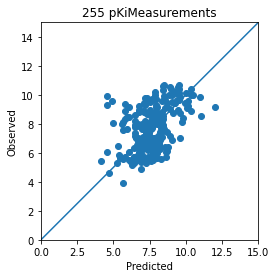

pKiMeasurement test
-------------------
 MAE: 1.27±0.13 95CI=(1.05, 1.51)
 MSE: 2.06±0.35 95CI=(1.49, 2.63)
  R2: 0.05±0.28 95CI=(-0.43, 0.37)
RMSE: 1.43±0.12 95CI=(1.22, 1.62)


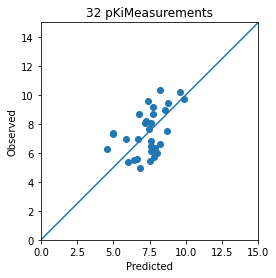


****************
pIC50Measurement train
----------------------
 MAE: 0.84±0.01 95CI=(0.82, 0.85)
 MSE: 1.10±0.02 95CI=(1.07, 1.13)
  R2: 0.15±0.02 95CI=(0.12, 0.18)
RMSE: 1.05±0.01 95CI=(1.03, 1.06)


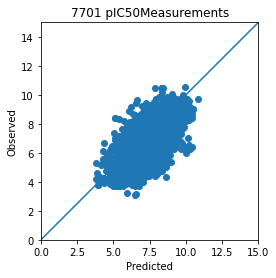

pIC50Measurement test
---------------------
 MAE: 0.87±0.03 95CI=(0.83, 0.91)
 MSE: 1.23±0.07 95CI=(1.12, 1.34)
  R2: 0.07±0.05 95CI=(-0.01, 0.16)
RMSE: 1.11±0.03 95CI=(1.06, 1.16)


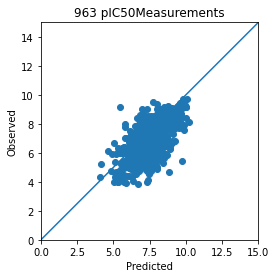


****************
pKdMeasurement train
--------------------
 MAE: 1.14±0.09 95CI=(0.98, 1.28)
 MSE: 1.87±0.25 95CI=(1.49, 2.27)
  R2: -0.48±0.27 95CI=(-1.02, -0.15)
RMSE: 1.36±0.09 95CI=(1.22, 1.51)


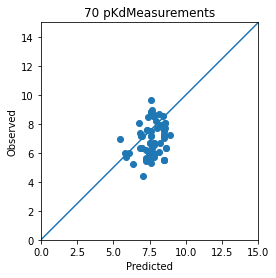

pKdMeasurement test
-------------------
 MAE: 1.20±0.33 95CI=(0.69, 1.73)
 MSE: 2.04±0.97 95CI=(0.60, 3.58)
  R2: -1.08±2.33 95CI=(-2.89, 0.11)
RMSE: 1.39±0.34 95CI=(0.78, 1.89)


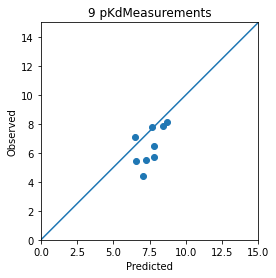


****************


In [18]:
for mtype in ["pKiMeasurement", "pIC50Measurement", "pKdMeasurement"]:
    for ttype in ["train", "test"]:
        indices = getattr(datamodules[mtype], f"{ttype}_dataloader")().sampler.indices
        observed = datamodules[mtype].dataset.data_y[indices]
        model_input = datamodules[mtype].dataset.data_X[indices]

        delta_g = model(model_input)
        prediction = obs_models[mtype](delta_g).detach().numpy()

        print(mtype, ttype)
        print("-"*(len(mtype)+len(ttype)+1))
        display(predicted_vs_observed(prediction, observed, limits=(0, 15), title=f"{prediction.shape[0]} {mtype}s", n_boot=100, sample_ratio=0.75))
    print("\n****************")

In [19]:
from kinoml.utils import watermark
watermark()

Watermark
---------
torch             1.6.0
pytorch_lightning 1.0.3
numpy             1.19.2
last updated: 2020-10-27 20:07:40 CET 2020-10-27T20:07:40+01:00

CPython 3.7.8
IPython 7.18.1

compiler   : GCC 7.5.0
system     : Linux
release    : 4.19.128-microsoft-standard
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
host name  : jrodriguez
Git hash   : fc320bcf36713a8f8e136b75fffe4a2b1c36283f
watermark 2.0.2

conda
-----
sys.version: 3.7.6 | packaged by conda-forge | (defau...
sys.prefix: /opt/miniconda
sys.executable: /opt/miniconda/bin/python
conda location: /opt/miniconda/lib/python3.7/site-packages/conda
conda-build: /opt/miniconda/bin/conda-build
conda-convert: /opt/miniconda/bin/conda-convert
conda-debug: /opt/miniconda/bin/conda-debug
conda-develop: /opt/miniconda/bin/conda-develop
conda-env: /opt/miniconda/bin/conda-env
conda-index: /opt/miniconda/bin/conda-index
conda-inspect: /opt/miniconda/bin/conda-inspect
conda-metapackage: /opt/miniconda/bin/con